### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, val_test_split
from specmf.data import load_data
from specmf.plot import *
from matplotlib.tri import Triangulation, tricontourf

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

In [3]:
def cost_fn(n_HF, n_LF, sigma, C_phi, inds_train):
    P_N = np.zeros((n_HF, n_LF))
    P_N[np.arange(n_HF), inds_train] = 1
    return np.linalg.norm(((1 / sigma ** 2) * C_phi @ P_N.T @ P_N) - np.eye(n_LF))


# Darcy-flow

In [44]:
dataset_name = "darcy-flow"

x_LF1, x_HF1 = load_data(
    dataset_name,
    preprocess=True,
    normalize=True, 
    flatten=True,
    )

print(f"{x_LF1.shape=}", f"{x_HF1.shape=}")

Loading Darcy flow data ...
x_LF1.shape=(3697, 10201) x_HF1.shape=(3697, 10201)


In [45]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF1 = Graph(data=x_LF1,
             **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full',
}
model1 = MultiFidelityModel(**model_config)

In [46]:
n_HF = 100
inds_train, labels = model1.cluster(g_LF1, n_HF)

x_HF_train1 = x_HF1[inds_train, :]

In [47]:
x_MF, C_phi, _ = model1.transform(g_LF1, x_HF_train1, inds_train)
cost = cost_fn(n_HF, x_LF1.shape[0], model1.sigma, C_phi, inds_train)

In [9]:
KAPPAS = np.logspace(-8, 0, 18)
BETAS = np.linspace(2, 7, 6)
ERRS1 = []
COST_FN1 = []
Ks1 = []
Bs1 = []

for kappa in KAPPAS:
    for beta in BETAS:
        model1.beta = int(beta)
        model1.kappa = kappa

        x_MF, C_phi, _ = model1.transform(g_LF1, x_HF_train1, inds_train)
        _, e_MF = error_analysis(
                x_LF1,
                x_MF,
                x_HF1,
                return_values=True,
                verbose=False,
            )
        ERRS1.append(e_MF)
        cost = cost_fn(n_HF, x_LF1.shape[0], model1.sigma, C_phi, inds_train)
        # cost = np.linalg.norm(x_MF - x_LF, axis=1).mean()
        COST_FN1.append(cost)   
        Ks1.append(kappa)
        Bs1.append(beta) 

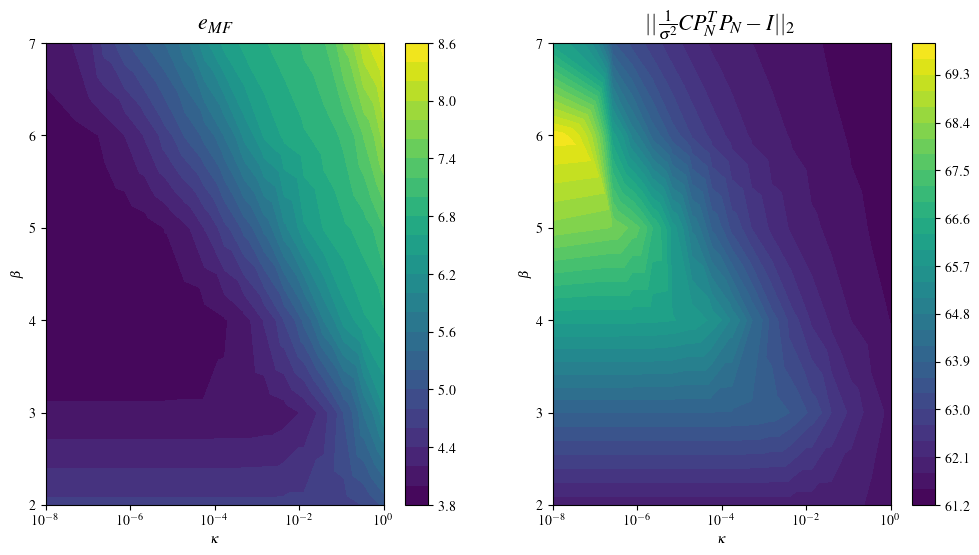

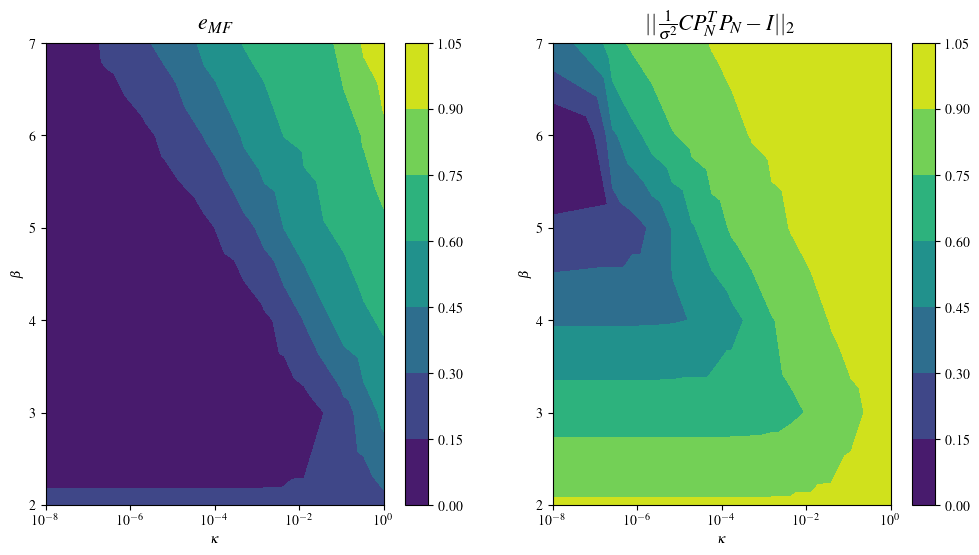

In [10]:
Ks, Bs = Ks1, Bs1
ERRS = ERRS1
COST_FN = COST_FN1

triang = Triangulation(Ks, Bs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax_err = ax1.tricontourf(triang, ERRS, levels=30)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN, levels=30)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ERRS = (np.array(ERRS) - np.array(ERRS).min()) / (np.array(ERRS).max() - np.array(ERRS).min())
COST_FN = 1 - (np.array(COST_FN) - np.array(COST_FN).min()) / (np.array(COST_FN).max() - np.array(COST_FN).min())

ax_err = ax1.tricontourf(triang, ERRS,)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN,)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)


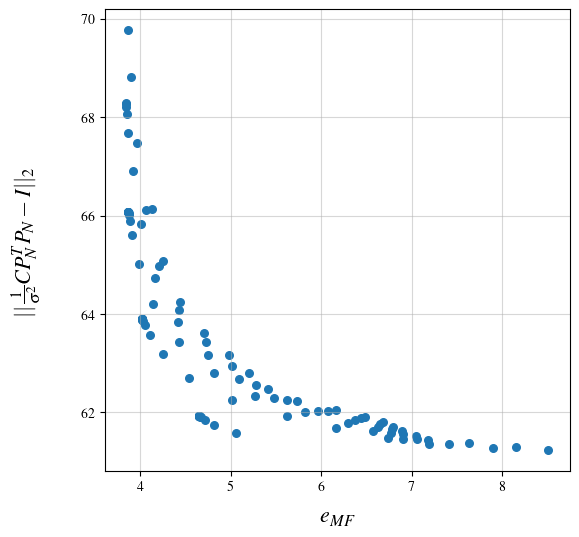

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = ERRS1
y = COST_FN1
ax.scatter(x, y, s=30)
ax.set_xlabel(r"$e_{MF}$",
              fontsize=16,
              labelpad=10)
ax.set_ylabel(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$", 
              fontsize=16,
              rotation=90,
              labelpad=30)
ax.grid(alpha=0.5)

# Inclusion-QoIs

In [12]:
dataset_name = "inclusion-qoi"

x_LF2, x_HF2 = load_data(
    dataset_name,
    preprocess=True,
    normalize=True, 
    flatten=True,
    )

x_LF2, x_HF2 = x_LF2[:3000], x_HF2[:3000]

print(f"{x_LF2.shape=}", f"{x_HF2.shape=}")

Loading inclusion QoIs data ...
x_LF2.shape=(3000, 5) x_HF2.shape=(3000, 5)


In [13]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF2 = Graph(data=x_LF2,
             **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full',
}
model2 = MultiFidelityModel(**model_config)

In [14]:
n_HF = 150
inds_train, labels = model2.cluster(g_LF2, n_HF)

x_HF_train2 = x_HF2[inds_train, :]

In [15]:
KAPPAS = np.logspace(-8, 0, 18)
BETAS = np.linspace(1, 4, 4)
ERRS2 = []
COST_FN2 = []
Ks2 = []
Bs2 = []

for kappa in KAPPAS:
    for beta in BETAS:
        model2.beta = int(beta)
        model2.kappa = kappa

        x_MF, C_phi, _ = model2.transform(g_LF2, x_HF_train2, inds_train)
        _, e_MF = error_analysis(
                x_LF2,
                x_MF,
                x_HF2,
                return_values=True,
                verbose=False,
            )
        ERRS2.append(e_MF)
        cost = cost_fn(n_HF, x_LF2.shape[0], model2.sigma, C_phi, inds_train)
        # cost = np.linalg.norm(x_MF - x_LF, axis=1).mean()
        COST_FN2.append(cost)   
        Ks2.append(kappa)
        Bs2.append(beta) 

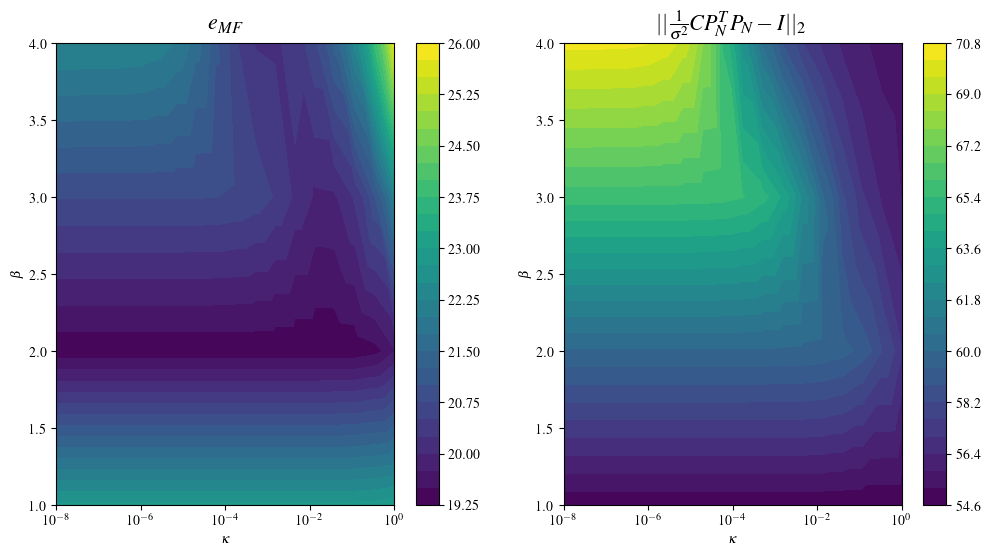

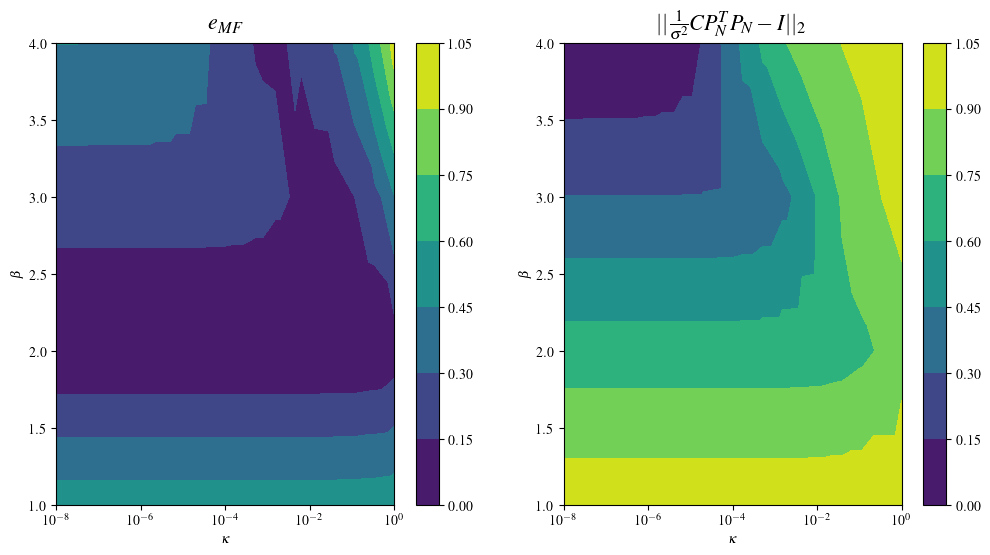

In [16]:
Ks, Bs = Ks2, Bs2
ERRS = ERRS2
COST_FN = COST_FN2

triang = Triangulation(Ks, Bs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax_err = ax1.tricontourf(triang, ERRS, levels=30)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN, levels=30)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ERRS = (np.array(ERRS) - np.array(ERRS).min()) / (np.array(ERRS).max() - np.array(ERRS).min())
COST_FN = 1 - (np.array(COST_FN) - np.array(COST_FN).min()) / (np.array(COST_FN).max() - np.array(COST_FN).min())

ax_err = ax1.tricontourf(triang, ERRS,)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN,)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

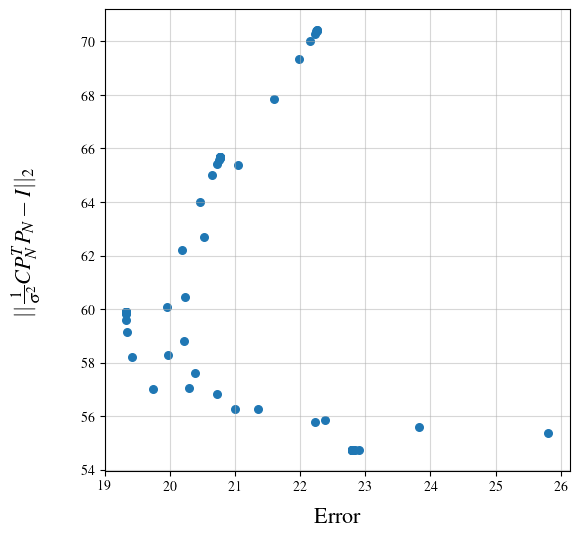

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = ERRS2
y = COST_FN2
ax.scatter(x, y, s=30)
ax.set_xlabel("Error",
              fontsize=16,
              labelpad=10)
ax.set_ylabel(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$", 
              fontsize=16,
              rotation=90,
              labelpad=30)
ax.grid(alpha=0.5)

# Inclusion-field

In [18]:
dataset_name = "inclusion-field"

x_LF3, x_HF3 = load_data(
    dataset_name,
    preprocess=True,
    normalize=True, 
    flatten=True,
    )

print(f"{x_LF3.shape=}", f"{x_HF3.shape=}")

Loading inclusion fields data ...
x_LF3.shape=(2972, 10201) x_HF3.shape=(2972, 10201)


In [19]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF3 = Graph(data=x_LF3,
             **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full',
}
model3 = MultiFidelityModel(**model_config)

In [20]:
n_HF = 100
inds_train, labels = model3.cluster(g_LF3, n_HF)

x_HF_train3 = x_HF3[inds_train, :]

In [21]:
KAPPAS = np.logspace(-6, 2, 18)
BETAS = np.linspace(1, 3, 3)
ERRS3 = []
COST_FN3 = []
Ks3 = []
Bs3 = []

for kappa in KAPPAS:
    for beta in BETAS:
        model3.beta = int(beta)
        model3.kappa = kappa

        x_MF, C_phi, _ = model3.transform(g_LF3, x_HF_train3, inds_train)
        _, e_MF = error_analysis(
                x_LF3,
                x_MF,
                x_HF3,
                return_values=True,
                verbose=False,
            )
        ERRS3.append(e_MF)
        cost = cost_fn(n_HF, x_LF3.shape[0], model3.sigma, C_phi, inds_train)
        # cost = np.linalg.norm(x_MF - x_LF, axis=1).mean()
        COST_FN3.append(cost)   
        Ks3.append(kappa)
        Bs3.append(beta) 

/Users/orazio/Desktop/codes/spectral-multifidelity/specmf/models.py:214: RuntimeWarning: invalid value encountered in sqrt
  dPhi = np.sqrt(np.diag(C_phi) + self.REG_EPS)


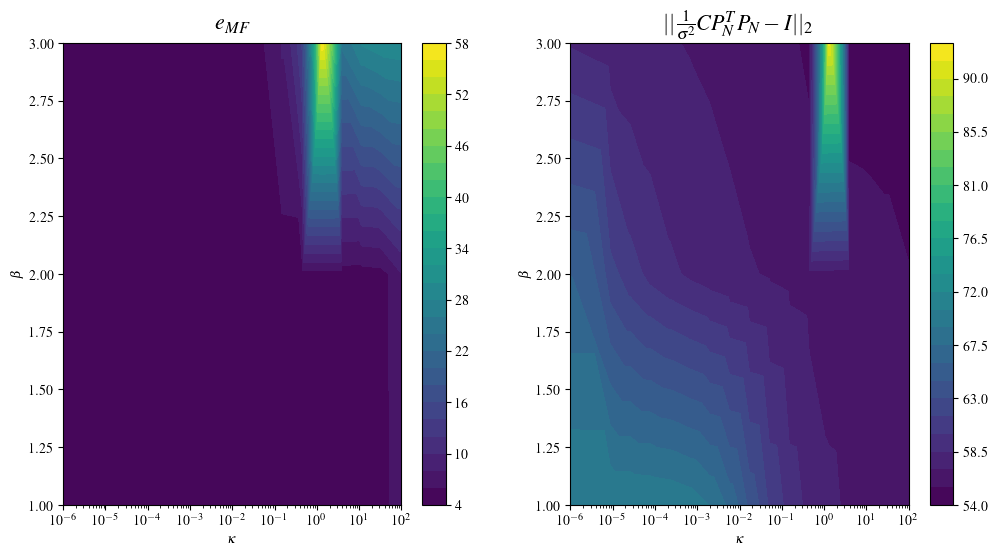

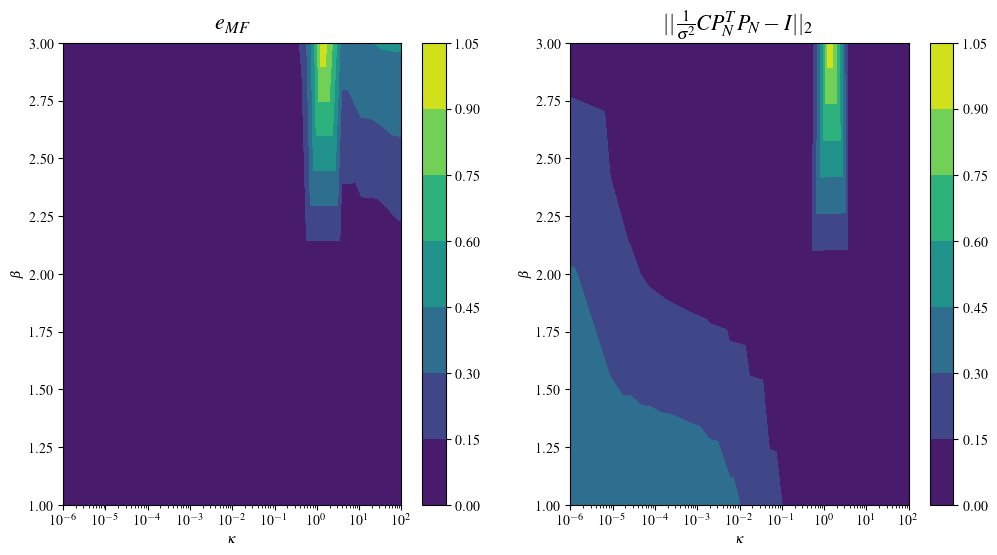

In [39]:
Ks, Bs = Ks3, Bs3
ERRS = ERRS3
COST_FN = COST_FN3
ERRS = np.array(ERRS)

triang = Triangulation(Ks, Bs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax_err = ax1.tricontourf(triang, ERRS, levels=30)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)
ax_phi = ax2.tricontourf(triang, COST_FN, levels=30)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ERRS = (np.array(ERRS) - np.array(ERRS).min()) / (np.array(ERRS).max() - np.array(ERRS).min())
COST_FN = (np.array(COST_FN) - np.array(COST_FN).min()) / (np.array(COST_FN).max() - np.array(COST_FN).min())

ax_err = ax1.tricontourf(triang, ERRS,)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN,)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

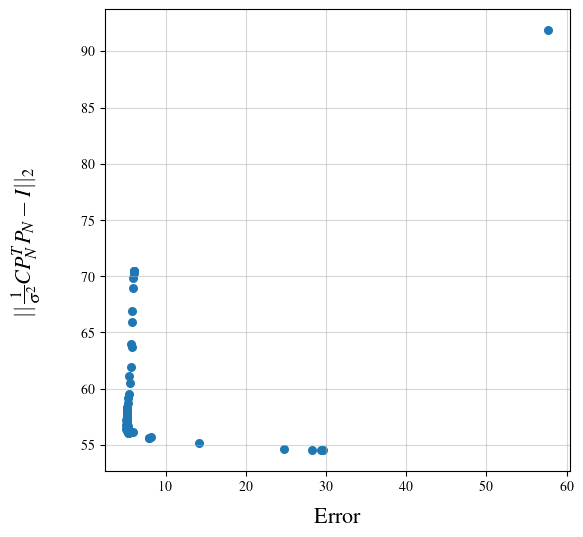

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = ERRS3
y = COST_FN3
ax.scatter(x, y, s=30)
ax.set_xlabel("Error",
              fontsize=16,
              labelpad=10)
ax.set_ylabel(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$", 
              fontsize=16,
              rotation=90,
              labelpad=30)
ax.grid(alpha=0.5)

# Beam

In [24]:
dataset_name = "beam"

x_LF4, x_HF4 = load_data(
    dataset_name,
    preprocess=True,
    normalize=False, 
    flatten=True,
    )

x_LF4, x_HF4 = x_LF4[:4000], x_HF4[:4000]

print(f"{x_LF4.shape=}", f"{x_HF4.shape=}")

Loading beam data ...
x_LF4.shape=(4000, 513) x_HF4.shape=(4000, 513)


In [25]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF4 = Graph(data=x_LF4,
             **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full',
}
model4 = MultiFidelityModel(**model_config)

In [26]:
n_HF = 50
inds_train, labels = model4.cluster(g_LF4, n_HF)

x_HF_train4 = x_HF4[inds_train, :]

In [27]:
KAPPAS = np.logspace(-4, 1, 12)
BETAS = np.linspace(1, 3, 3)
ERRS4 = []
COST_FN4 = []
Ks4 = []
Bs4 = []

for kappa in KAPPAS:
    for beta in BETAS:
        model4.beta = int(beta)
        model4.kappa = kappa

        x_MF, C_phi, _ = model4.transform(g_LF4, x_HF_train4, inds_train)
        _, e_MF = error_analysis(
                x_LF4,
                x_MF,
                x_HF4,
                return_values=True,
                verbose=False,
            )
        ERRS4.append(e_MF)
        cost = cost_fn(n_HF, x_LF4.shape[0], model4.sigma, C_phi, inds_train)
        # cost = np.linalg.norm(x_MF - x_LF, axis=1).mean()
        COST_FN4.append(cost)   
        Ks4.append(kappa)
        Bs4.append(beta) 

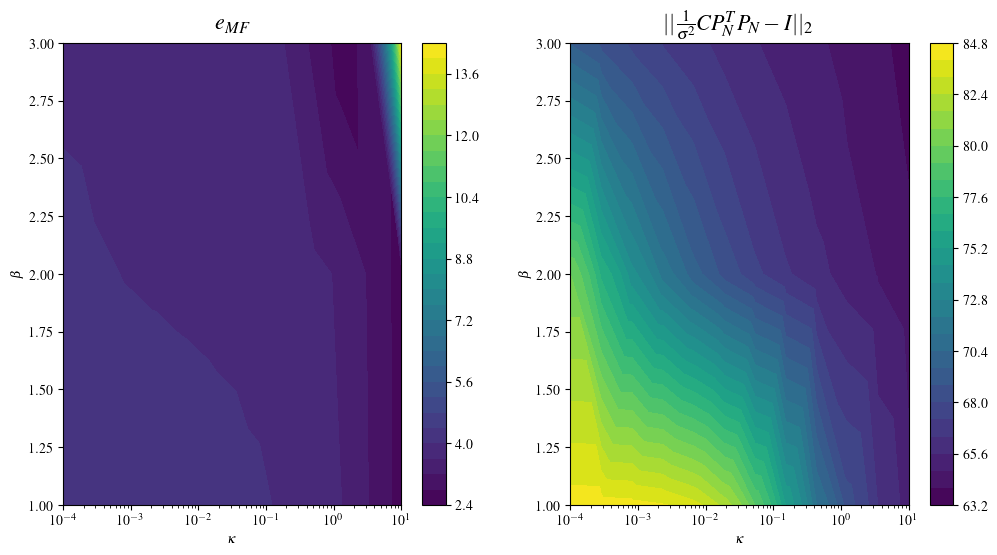

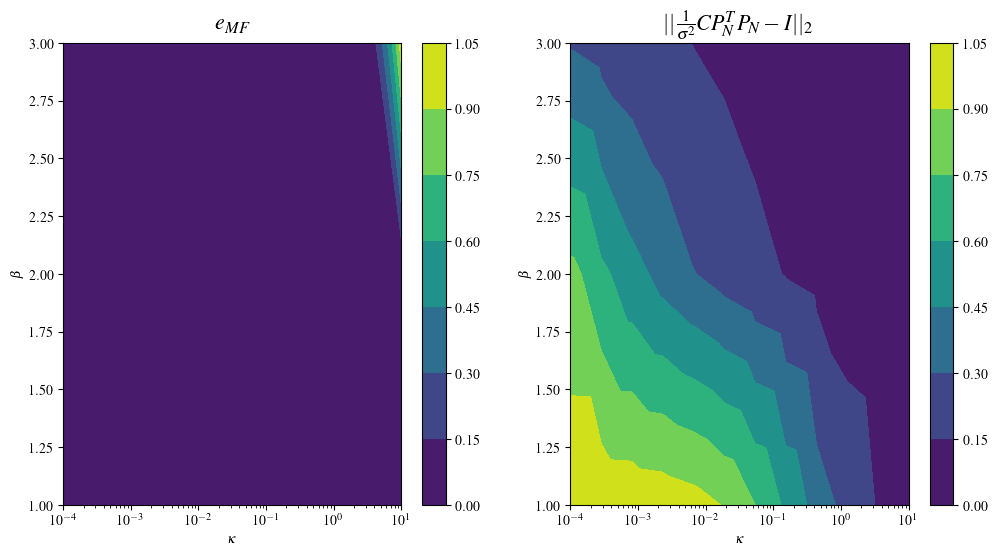

In [43]:
Ks, Bs = Ks4, Bs4
ERRS = ERRS4
COST_FN = COST_FN4

triang = Triangulation(Ks, Bs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax_err = ax1.tricontourf(triang, ERRS, levels=30)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN, levels=30)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ERRS = (np.array(ERRS) - np.array(ERRS).min()) / (np.array(ERRS).max() - np.array(ERRS).min())
COST_FN = (np.array(COST_FN) - np.array(COST_FN).min()) / (np.array(COST_FN).max() - np.array(COST_FN).min())

ax_err = ax1.tricontourf(triang, ERRS,)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN,)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

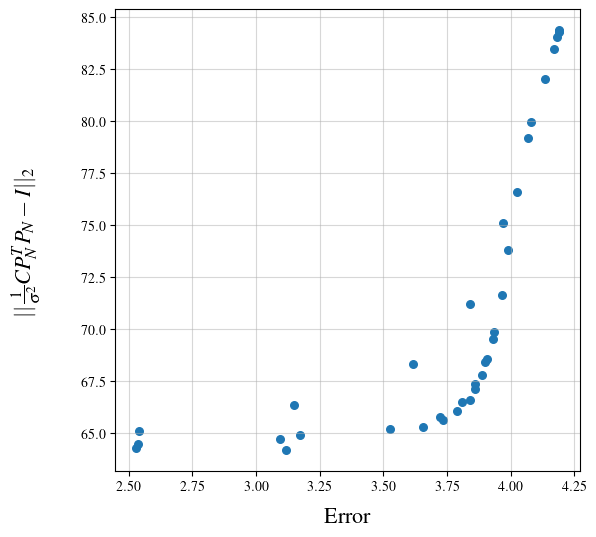

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = np.array(ERRS4)
mask = x < 6
x = x[mask]
y = np.array(COST_FN4)
y = y[mask]
ax.scatter(x, y, s=30)
ax.set_xlabel("Error",
              fontsize=16,
              labelpad=10)
ax.set_ylabel(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$", 
              fontsize=16,
              rotation=90,
              labelpad=30)
ax.grid(alpha=0.5)

# Cavity

In [30]:
dataset_name = "cavity"

x_LF5, x_HF5 = load_data(
    dataset_name,
    preprocess=True,
    normalize=False, 
    flatten=True,
    )

x_LF5, x_HF5 = x_LF5[:4000], x_HF5[:4000]

print(f"{x_LF5.shape=}", f"{x_HF5.shape=}")

Loading cavity data ...
x_LF5.shape=(4000, 221) x_HF5.shape=(4000, 221)


In [31]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF5 = Graph(data=x_LF5,
             **graph_config)

# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'full',
}
model5= MultiFidelityModel(**model_config)

In [32]:
n_HF = 150
inds_train, labels = model5.cluster(g_LF5, n_HF)

x_HF_train5 = x_HF5[inds_train, :]

In [33]:
KAPPAS = np.logspace(-6, 0, 14)
BETAS = np.linspace(1, 3, 3)
ERRS5 = []
COST_FN5 = []
Ks5 = []
Bs5 = []

for kappa in KAPPAS:
    for beta in BETAS:
        model5.beta = int(beta)
        model5.kappa = kappa

        x_MF, C_phi, _ = model5.transform(g_LF5, x_HF_train5, inds_train)
        _, e_MF = error_analysis(
                x_LF5,
                x_MF,
                x_HF5,
                return_values=True,
                verbose=False,
            )
        ERRS5.append(e_MF)
        cost = cost_fn(n_HF, x_LF5.shape[0], model5.sigma, C_phi, inds_train)
        # cost = np.linalg.norm(x_MF - x_LF, axis=1).mean()
        COST_FN5.append(cost)   
        Ks5.append(kappa)
        Bs5.append(beta) 

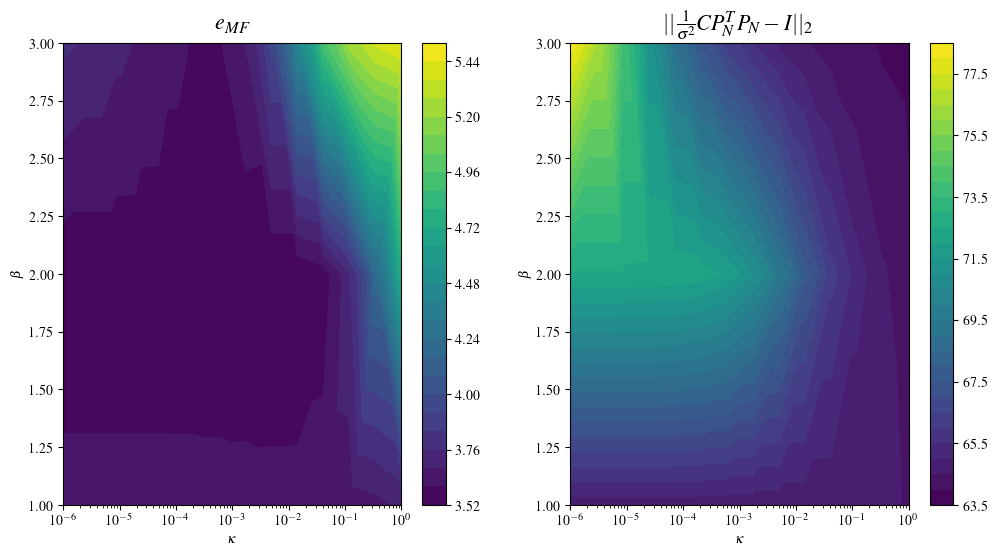

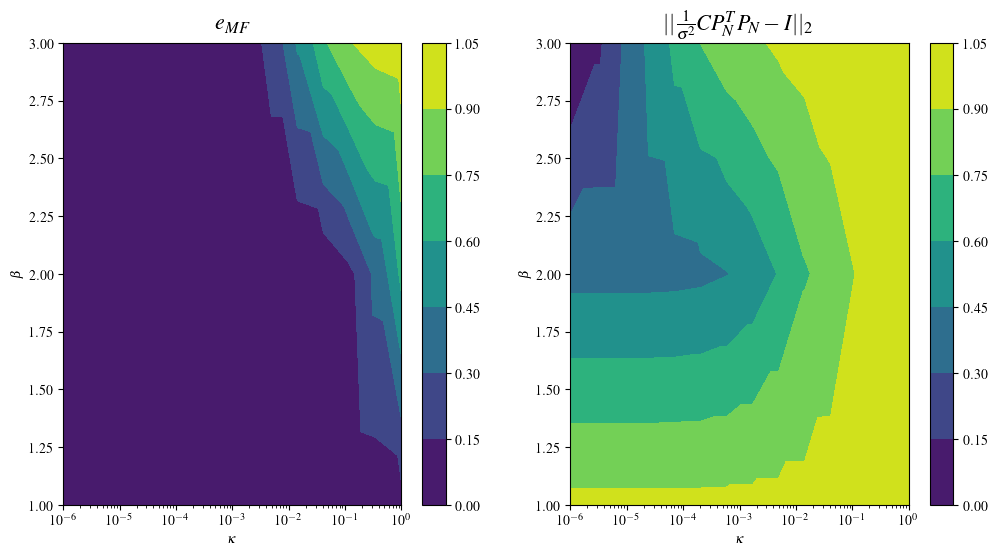

In [34]:
Ks, Bs = Ks5, Bs5
ERRS = ERRS5
COST_FN = COST_FN5

triang = Triangulation(Ks, Bs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax_err = ax1.tricontourf(triang, ERRS, levels=30)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN, levels=30)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ERRS = (np.array(ERRS) - np.array(ERRS).min()) / (np.array(ERRS).max() - np.array(ERRS).min())
COST_FN = 1 - (np.array(COST_FN) - np.array(COST_FN).min()) / (np.array(COST_FN).max() - np.array(COST_FN).min())

ax_err = ax1.tricontourf(triang, ERRS,)
ax1.set_xlabel(r"$\kappa$")
ax1.set_ylabel(r"$\beta$")
ax1.set_xscale('log')
ax1.set_title(r"$e_{MF}$",
              fontsize=16,
              pad=10)

ax_phi = ax2.tricontourf(triang, COST_FN,)
ax2.set_xlabel(r"$\kappa$")
ax2.set_ylabel(r"$\beta$")
ax2.set_xscale('log')
ax2.set_title(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$",
              fontsize=16,
              pad=10)

plt.colorbar(ax_phi, ax=ax2)
plt.colorbar(ax_err, ax=ax1)

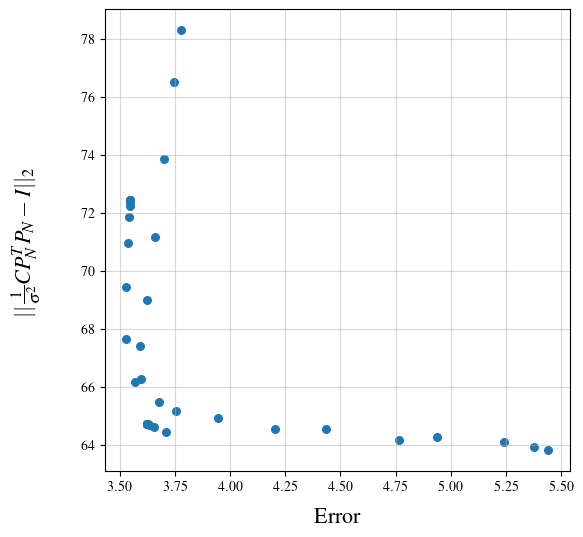

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x = ERRS5
y = COST_FN5
ax.scatter(x, y, s=30)
ax.set_xlabel("Error",
              fontsize=16,
              labelpad=10)
ax.set_ylabel(r"$||\frac{1}{\sigma^2}C P_N^T P_N - I||_2$", 
              fontsize=16,
              rotation=90,
              labelpad=30)
ax.grid(alpha=0.5)